# Layout:
1. Import Packages/Libraries
2. Read Data From Previous Scrape
3. Clean + Feature Engineer Data
    + Drop Duplicates
    + Set Column Values
    + Turn Categorical Data into 0/1 Variables
    + Drop Movies
4. Split into Train and Test Set
5. EDA on Training Set
    + Pairplot
    + Correlations
6. Base Model- Patsy
7. Diagnostic Plots
8. Scale/Normalize Values
    + Log Dependent Variable
9. EDA Scaled Values
10. Regression on Logged Values
11. Lasso Regularization

**Can't Log/Polynomial Independent Variables as Needed**


12. More Advanced Model

# Mass Importation

In [1]:
import pandas as pd
import numpy as np
import dateutil.parser
from datetime import date
import re

from bs4 import BeautifulSoup
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import os

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from scipy import stats
from sklearn import linear_model,ensemble, tree, model_selection, datasets

import diagnostic_plots

import pickle
import time

/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Read Dataset from Scrape

In [2]:
df=pd.read_csv('steam3.csv')
del(df['Unnamed: 0'])
df.set_index('title', inplace=True)
df.head()

,link,system,systems,reviews,release_date,discount,price
title,,,,,,,
Warframe,https://store.steampowered.com/app/230410/Warf...,1,['win'],192592,1940,0,0.00
Clicker Heroes 2,https://store.steampowered.com/app/629910/Clic...,2,"['win', 'mac']",183,1,0,29.99
Tom Clancy's Rainbow Six® Siege,https://store.steampowered.com/app/359550/Tom_...,1,['win'],170518,959,0,14.99
Counter-Strike: Global Offensive,https://store.steampowered.com/app/730/Counter...,3,"['win', 'mac', 'linux']",2628652,2156,0,14.99
Grand Theft Auto V,https://store.steampowered.com/app/271590/Gran...,1,['win'],343780,1191,34,29.99


# Clean Data and Add Dummy Features

Remove Duplicates

In [3]:
no_dup_df = df[~df.index.duplicated(keep='first')]

Set Column Value Types

In [4]:
no_dup_df['system'] = no_dup_df.system.astype(int)
no_dup_df['reviews'] = no_dup_df.reviews.astype(int)
no_dup_df['release_date'] = no_dup_df.release_date.astype(int)
no_dup_df['discount'] = no_dup_df.discount.astype(int)
no_dup_df['price'] = no_dup_df.price.astype(float)
no_dup_df['systems'] = no_dup_df.systems.astype(list)

/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

## Windows, Mac, Linux -> Dummy Variables

In [5]:
windows=[1 if 'win' in item else 0 for item in no_dup_df.systems]
mac=[1 if 'mac' in item else 0 for item in no_dup_df.systems]
linux=[1 if 'linux' in item else 0 for item in no_dup_df.systems]

In [6]:
no_dup_df['windows']=windows
no_dup_df['mac']=mac
no_dup_df['linux']=linux

/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [7]:
no_dup_df['windows'] = no_dup_df.windows.astype(int)
no_dup_df['mac'] = no_dup_df.mac.astype(int)
no_dup_df['linux'] = no_dup_df.linux.astype(int)
#no_dup_df.info()

/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

## Drop Movies

In [8]:
movies=[]
for i in range(len(no_dup_df['systems'])):
    element=(no_dup_df['systems'][i])
    if 'win' not in element and 'mac' not in element and 'linux' not in element:
        movies.append(1)
    else:
        movies.append(0)
no_dup_df['movies']=movies
no_dup_df = no_dup_df[no_dup_df.movies != 1]
del(no_dup_df['movies'])

/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Split Data into Train/Test

In [9]:
y = no_dup_df['price']
X = no_dup_df.drop(['price','link','systems'], axis = 1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
traindf=X_train.join(y_train)

# Exploratory Data Analysis on Train Data

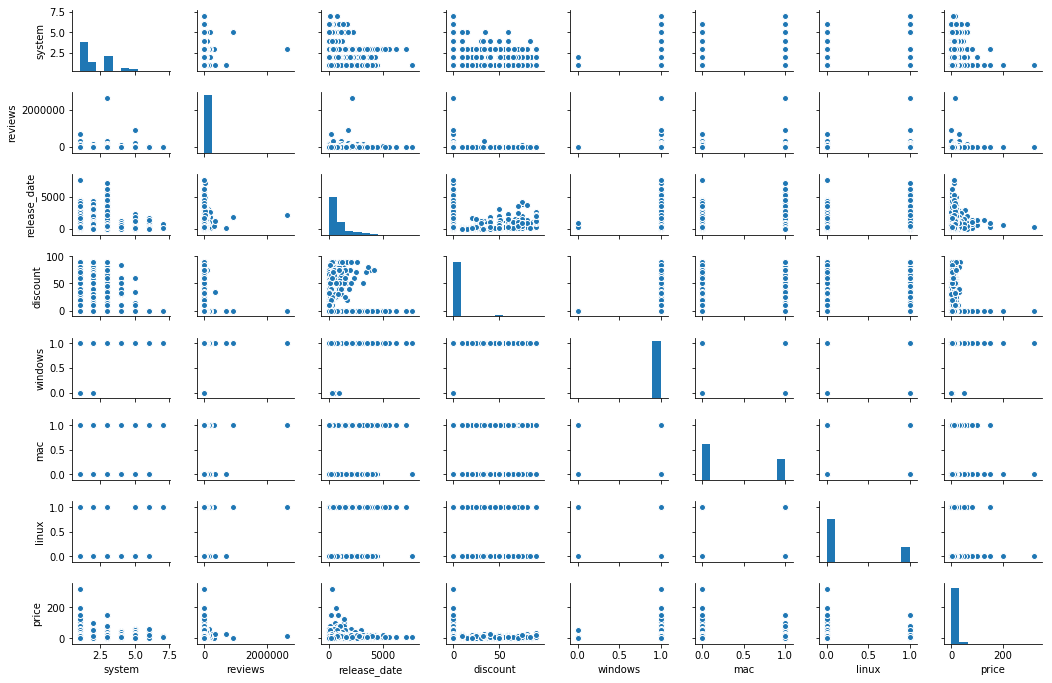

In [11]:
sns.pairplot(traindf, size = 1.2, aspect=1.5)

In [12]:
traindf.corr()
#sns.heatmap(no_dup_df.corr(), cmap="seismic")

,system,reviews,release_date,discount,windows,mac,linux,price
system,1.000000,0.032177,-0.071030,-0.030166,0.012703,0.512563,0.544346,0.026318
reviews,0.032177,1.000000,0.048136,-0.002004,0.001423,0.037485,0.049081,0.038910
release_date,-0.071030,0.048136,1.000000,-0.030116,0.005206,0.076431,0.044253,0.051384
discount,-0.030166,-0.002004,-0.030116,1.000000,0.005328,0.006014,0.003146,-0.053075
windows,0.012703,0.001423,0.005206,0.005328,1.000000,-0.014283,-0.021938,-0.018152
mac,0.512563,0.037485,0.076431,0.006014,-0.014283,1.000000,0.646092,-0.002126
linux,0.544346,0.049081,0.044253,0.003146,-0.021938,0.646092,1.000000,0.000020
price,0.026318,0.038910,0.051384,-0.053075,-0.018152,-0.002126,0.000020,1.000000


# Base Model

In [13]:
model = sm.OLS(y_train, sm.add_constant(X_train))
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     6.638
Date:                Wed, 18 Jul 2018   Prob (F-statistic):           7.67e-08
Time:                        17:56:16   Log-Likelihood:                -20922.
No. Observations:                5443   AIC:                         4.186e+04
Df Residuals:                    5435   BIC:                         4.191e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           17.8758      6.535      2.735      0.006       5.064      30.687
system           0.4856      0.171      2.837      0.005       0.150       0.821
reviews       1.022e-05   3.81e-06      2.683      0.007    2.75e-06    1.77e-05
release_date     0.0007      0.000      3.943      0.000       0.000       0.001
discount        -0.0446      0.012     -3.670      0.000      -0.068      -0.021
windows         -9.4269      6.536     -1.442      0.149     -22.241       3.387
mac             -0.5001      0.431     -1.160      0.246      -1.345       0.345
linux           -0.4313      0.486     -0.887      0.375      -1.384       0.522
==============================================================================
Omnibus:                     7435.340   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4441143.130
Skew:                           7.470   Prob(JB):                         0.00
Kurtosis:                     142.138   Cond. No.                     2.43e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.43e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Diagnostic Plots

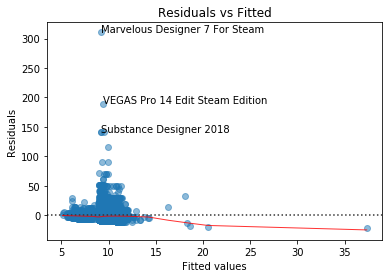

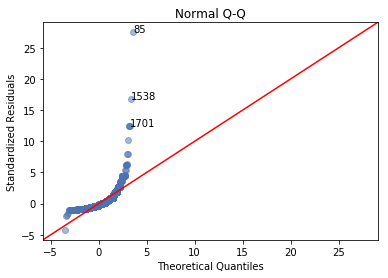

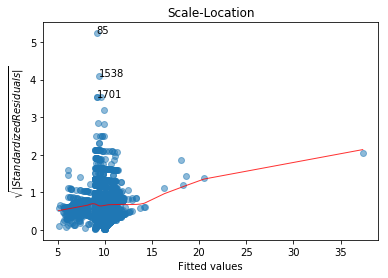

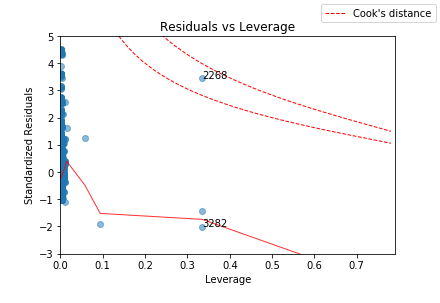

In [14]:
y_traindf=pd.DataFrame(y_train)
X_traindf=pd.DataFrame(X_train)
diagnostic_plots.diagnostic_plots(X_traindf, y_traindf, fit)

# Reviews/Normalize Data

Log Data

(array([ 426.,  766.,  568., 1316., 1590.,  628.,  105.,   38.,    4.,
           2.]),
 array([0.        , 0.57714411, 1.15428822, 1.73143234, 2.30857645,
        2.88572056, 3.46286467, 4.04000879, 4.6171529 , 5.19429701,
        5.77144112]),
 <a list of 10 Patch objects>)

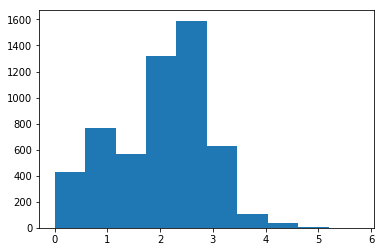

In [15]:
traindf['log_price'] = np.log(traindf.price + 1)
plt.hist(traindf['log_price'])

Boxcox- F

In [ ]:
yt, _ = stats.boxcox(traindf['reviews'])

# EDA Scaled Data, Log Reviews as Dependent

In [ ]:
sns.pairplot(traindf)

In [ ]:
traindf.corr()

# Regression on Log Values

In [ ]:
y2 = traindf['log_reviews']
X2 = traindf.drop(['log_reviews'], axis = 1)

model2 = sm.OLS(y2, sm.add_constant(X2))
fit2 = model2.fit()
fit2.summary()

# Regularize

In [ ]:
alphas = [10**x for x in range(-12, 5)]
scores = np.zeros((len(alphas),1))

In [ ]:
for j in range(len(alphas)):
    kf_score = []
    for train, test in kf:
        X_train = X.iloc[train]
        y_train = y.iloc[train]
        X_test = X.iloc[test]
        y_test = y.iloc[test]
        std_scaler = preprocessing.StandardScaler()
        X_train_norm = std_scaler.fit_transform(X_train)
        X_test_norm = std_scaler.transform(X_test)
    
        model =  Lasso(alpha = alphas[j])
        model.fit(X_train_norm, y_train)
        y_test_predict = model.predict(X_test_norm)
        score = mean_squared_error(y_test_predict, y_test)
        kf_score.append(score)
    scores[j] = np.mean(kf_score)
print ('mse for all alpha values \n')
print (pd.DataFrame(list(zip(alphas, scores)), columns=['alpha', 'mse']))

In [ ]:
best_alpha = alphas[scores.argmin()]
print ('alpha:', best_alpha)

In [ ]:
std_scaler = preprocessing.StandardScaler()
X_norm = std_scaler.fit_transform(X)

final_model =  Lasso(alpha = best_alpha)
final_model.fit(X_norm, y)
y_predict = final_model.predict(X_norm)
final_model_score = mean_squared_error(y_predict, y)
print ('MSE:', final_model_score)

In [ ]:
df_coef = pd.DataFrame(list(zip(X.columns, final_model.coef_)), columns = ['variable', 'coefficient'])
print ('Keep')
print (df_coef[df_coef['coefficient']!=0])

In [ ]:
print ('Drop')
print (df_coef[df_coef['coefficient']==0])

# More Complicated Models

In [ ]:
def get_scores(X, y, folds = 10, alpha = 0.5): 

    models = {}
    parameters = {}
    
    models['linear_model'] = linear_model.LinearRegression()
    models['ridge_model'] = linear_model.Ridge()
    models['lasso_model'] = linear_model.Lasso(alpha=alpha)
    models['robust_regression'] = linear_model.SGDRegressor(loss='huber',max_iter=2000)
    models['eps_insensitive'] = linear_model.SGDRegressor(loss='epsilon_insensitive',max_iter=2000)
    models['cart'] = tree.DecisionTreeRegressor(max_depth=7)
    models['extratrees'] = tree.ExtraTreeRegressor(max_depth=7)
    models['randomForest'] = ensemble.RandomForestRegressor()
    models['adaboostedTrees'] = ensemble.AdaBoostRegressor()
    models['gradboostedTrees'] = ensemble.GradientBoostingRegressor()
    
    score_list = []
    for name,model in models.items():
        scores = model_selection.cross_val_score(model, X, y, 
                                                 cv = folds, n_jobs=1, scoring="r2")  
        score_list.append(np.mean(scores))

    scores_df = pd.DataFrame({'Model': list(models.keys()),
                             'Scores': score_list})

    return scores_df

In [ ]:
get_scores(X_train,y_train, folds = 10, alpha = 0.5)

In [ ]:
get_scores(X2, y2, folds = 10, alpha = 0.5)

# Run RandomForest on Test

# Compare to Actual Values- Scores and Plotting